In [25]:
# filtrar los datos de 2024 solo para el mes de enero
import pandas as pd
# Cargar el archivo CSV
df = pd.read_csv('../data/processed/recorridos/trips_2024.csv')

recorridos_enero = df[df['fecha_origen_recorrido'].str.startswith('2024-01')]
# Guardar el DataFrame filtrado en un nuevo archivo CSV


#ordenar cronoligacamente
recorridos_enero = recorridos_enero.sort_values(by='fecha_destino_recorrido')

#filtrar para la estación con id_estacion_destino = 85
recorridos_enero = recorridos_enero[recorridos_enero['id_estacion_destino'] == 85]

# Guardar el DataFrame filtrado en un nuevo archivo CSV


recorridos_enero.to_csv('../data/processed/recorridos/trips_enero_2024.csv', index=False)


recorridos_enero.head()


,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
742047,20181085,265,2024-01-01 01:11:48,69,069 - Ecuador,"1226 Ecuador & Mansilla, Lucio Norberto, General",-58.404609,-34.596101,2024-01-01 01:16:13,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,1030865.0,FIT,FEMALE
772861,20181921,332,2024-01-01 06:53:33,96,096 - Carlos Gardel,3302 Guardia Vieja & Aguero,-58.411659,-34.602781,2024-01-01 06:59:05,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,984950.0,FIT,FEMALE
948313,20182023,39,2024-01-01 07:53:15,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,2024-01-01 07:53:54,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,949424.0,FIT,FEMALE
928464,20182245,3655,2024-01-01 11:03:53,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,2024-01-01 12:04:48,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,598754.0,FIT,MALE
741584,20182588,590,2024-01-01 12:59:22,492,325 - MEDRANO,3905 Bartolomé Mitre,-58.421563,-34.609710,2024-01-01 13:09:12,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,9480.0,FIT,FEMALE


In [ ]:
import pandas as pd

# Cargar datos ya filtrados
df = pd.read_csv('../data/processed/recorridos/trips_enero_2024.csv')

# Convertir fechas a datetime
df['fecha_destino_recorrido'] = pd.to_datetime(df['fecha_destino_recorrido'])

# Crear columna con ventana de 30 minutos
df['ventana_30min'] = df['fecha_destino_recorrido'].dt.floor('30min')

# Contar llegadas por ventana
conteo_llegadas = df.groupby('ventana_30min').size().reset_index(name='bicicletas_llegan')

# Crear rango completo de tiempo para enero
start_date = '2024-01-01 00:00:00'
end_date = '2024-01-31 23:59:59'
rango_completo = pd.date_range(start=start_date, end=end_date, freq='30min')

# Crear DataFrame con rango completo 

df_completo = pd.DataFrame({'ventana_30min': rango_completo})

# Combinar con conteo real
df_final = df_completo.merge(conteo_llegadas, on='ventana_30min', how='left')
df_final['bicicletas_llegan'] = df_final['bicicletas_llegan'].fillna(0).astype(int)

# Ordenar por tiempo
df_final = df_final.sort_values('ventana_30min').reset_index(drop=True)

# Guardar resultado
df_final.to_csv('../data/processed/recorridos/llegadas_estacion85_enero_30min.csv', index=False)


df_final['dia_semana'] = df_final['ventana_30min'].dt.dayofweek

# Lags de llegadas
for lag in [1, 2, 3]:
    df_final[f'lag_{lag}'] = df_final['bicicletas_llegan'].shift(lag)

#cambiar los primeros valores de lag a 0
df_final.loc[df_final.index < 3, ['lag_1', 'lag_2', 'lag_3']] = 0


# Agrupar por ventana y género para contar
conteo_genero = df.groupby(['ventana_30min', 'genero']).size().reset_index(name='conteo')

# Pivot para obtener columnas separadas para cada género
conteo_genero_pivot = conteo_genero.pivot(index='ventana_30min', columns='genero', values='conteo').fillna(0).astype(int)

conteo_genero_pivot.columns = ['llegan_genero_femenino' if col == 'FEMALE' else
                               'llegan_genero_masculino' if col == 'MALE' else
                               'llegan_genero_otro' for col in conteo_genero_pivot.columns]

# Resetear índice para poder hacer merge
conteo_genero_pivot = conteo_genero_pivot.reset_index()

# Unir con el dataframe final
df_final = df_final.merge(conteo_genero_pivot, on='ventana_30min', how='left')

# Rellenar con ceros donde no hubo llegadas
df_final[['llegan_genero_femenino', 'llegan_genero_masculino', 'llegan_genero_otro']] = df_final[[
    'llegan_genero_femenino', 'llegan_genero_masculino', 'llegan_genero_otro'
]].fillna(0).astype(int)


#agregar las estaciones de origen de los arribos, osea de donde vinieron,

#dropear los nans
df_final = df_final.dropna()





df_final.head(50)




,ventana_30min,bicicletas_llegan,dia_semana,lag_1,lag_2,lag_3,llegan_genero_femenino,llegan_genero_masculino,llegan_genero_otro
0,2024-01-01 00:00:00,0,0,0.0,0.0,0.0,0,0,0
1,2024-01-01 00:30:00,0,0,0.0,0.0,0.0,0,0,0
2,2024-01-01 01:00:00,1,0,0.0,0.0,0.0,1,0,0
3,2024-01-01 01:30:00,0,0,1.0,0.0,0.0,0,0,0
4,2024-01-01 02:00:00,0,0,0.0,1.0,0.0,0,0,0
5,2024-01-01 02:30:00,0,0,0.0,0.0,1.0,0,0,0
6,2024-01-01 03:00:00,0,0,0.0,0.0,0.0,0,0,0
7,2024-01-01 03:30:00,0,0,0.0,0.0,0.0,0,0,0
8,2024-01-01 04:00:00,0,0,0.0,0.0,0.0,0,0,0
9,2024-01-01 04:30:00,0,0,0.0,0.0,0.0,0,0,0


In [18]:
#preparar los datos para el modelo

import numpy as np
from sklearn.model_selection import train_test_split

# Seleccionar características y objetivo
X = df_final[[ 'dia_semana', 'lag_1', 'lag_2', 'lag_3']]
y = df_final['bicicletas_llegan']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(1190, 4) (298, 4)


MSE: 1.0076240955211795, R2: 0.2211996050457561


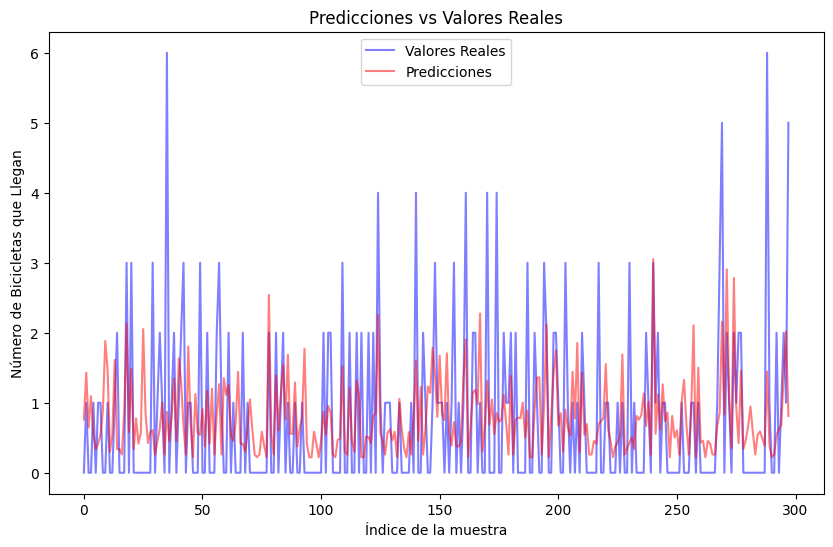

In [19]:
#hacer una rgresión lineal
from sklearn.linear_model import LinearRegression
# Crear el modelo
modelo = LinearRegression()
# Entrenar el modelo
modelo.fit(X_train, y_train)
# Hacer predicciones
predicciones = modelo.predict(X_test)
# Evaluar el modelo
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)
print(f'MSE: {mse}, R2: {r2}')


#graficar las predicciones vs los valores reales
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reales', color='blue', alpha=0.5)
plt.plot(predicciones, label='Predicciones', color='red', alpha=0.5)
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice de la muestra')
plt.ylabel('Número de Bicicletas que Llegan')
plt.legend()
plt.show()
